# Fine-tuned Named Entity Recognition with FiNER dataset.

Below are all steps needed in order to fine-tune a DistilBERT-based model for the downstream task of Named Entity Recognition. The dataset used for fine-tune is the FiNER-139 dataset, a collection of 1.1M sentences annotated with eXtensive Business Reporting Language (XBRL) tags extracted from annual and quarterly reports of publicly-traded companies in the US.

The intent of this notebook is to fine-tune with only a subset of the FiNER, with a selected set of tags.

### Project setup
The next 3 cells install all the libraries needed for running the code. It was mainly intended for running into a notebook-only environment such as Colab.

Uncomment the lines when running for the first time if the environment does not contain the libraries.

In [2]:
# !pip install torch numpy pandas matplotlib seaborn scikit-learn

In [3]:
# !pip install accelerate

In [4]:
# !pip install transformers datasets seqeval

In [5]:
# !pip install transformers[onnx]

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import datasets

### Load FiNER dataset
Load the FiNER-139 dataset from [Hugginface](https://huggingface.co/datasets/nlpaueb/finer-139).

"FiNER-139 is comprised of 1.1M sentences annotated with eXtensive Business Reporting Language (XBRL) tags extracted from annual and quarterly reports of publicly-traded companies in the US. Unlike other entity extraction tasks, like named entity recognition (NER) or contract element extraction, which typically require identifying entities of a small set of common types (e.g., persons, organizations), FiNER-139 uses a much larger label set of 139 entity types. Another important difference from typical entity extraction is that FiNER focuses on numeric tokens, with the correct tag depending mostly on context, not the token itself."

In [7]:
finer_data = datasets.load_dataset("nlpaueb/finer-139")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/900384 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/112494 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/108378 [00:00<?, ? examples/s]

In [8]:
finer_data

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 900384
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 112494
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 108378
    })
})

Set the format to pandas to make it easier to explore as a Pandas DataFrame.

In [9]:
finer_data.set_format("pandas")

In [10]:
finer_data["train"][:3]


,id,tokens,ner_tags
0,0,"[ITEM, 1, Financial, Statements, Lennar, Corpo...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,"[See, accompanying, notes, to, condensed, cons...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"[The, condensed, consolidated, financial, stat...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [11]:
finer_data["train"][:-3]


,id,tokens,ner_tags
0,0,"[ITEM, 1, Financial, Statements, Lennar, Corpo...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,"[See, accompanying, notes, to, condensed, cons...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"[The, condensed, consolidated, financial, stat...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,"[These, condensed, consolidated, financial, st...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,"[The, condensed, consolidated, statements, of,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
900376,900376,"[In, the, event, that, the, company, ’, s, lev...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
900377,900377,"[In, the, second, quarter, of, 2019, ,, the, c...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
900378,900378,"[As, a, result, ,, for, the, three, months, en...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
900379,900379,"[Fee, income, earned, from, these, arrangement...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [12]:
finer_data["train"]['ner_tags'][:3]

0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: ner_tags, dtype: object

Get all the available 139 Entity types. They are broken down in B (Begin), I (Interior) tags for entities with more than one word.

In [13]:
ner_tag_labels = finer_data["train"].features['ner_tags'].feature.names
print(len(ner_tag_labels))
ner_tag_labels

279


['O',
 'B-AccrualForEnvironmentalLossContingencies',
 'B-AcquiredFiniteLivedIntangibleAssetsWeightedAverageUsefulLife',
 'I-AcquiredFiniteLivedIntangibleAssetsWeightedAverageUsefulLife',
 'B-AllocatedShareBasedCompensationExpense',
 'B-AmortizationOfFinancingCosts',
 'B-AmortizationOfIntangibleAssets',
 'I-AmortizationOfIntangibleAssets',
 'B-AntidilutiveSecuritiesExcludedFromComputationOfEarningsPerShareAmount',
 'I-AntidilutiveSecuritiesExcludedFromComputationOfEarningsPerShareAmount',
 'B-AreaOfRealEstateProperty',
 'I-AreaOfRealEstateProperty',
 'B-AssetImpairmentCharges',
 'B-BusinessAcquisitionEquityInterestsIssuedOrIssuableNumberOfSharesIssued',
 'B-BusinessAcquisitionPercentageOfVotingInterestsAcquired',
 'I-BusinessAcquisitionPercentageOfVotingInterestsAcquired',
 'B-BusinessCombinationAcquisitionRelatedCosts',
 'B-BusinessCombinationConsiderationTransferred1',
 'B-BusinessCombinationContingentConsiderationLiability',
 'B-BusinessCombinationRecognizedIdentifiableAssetsAcquired

Get a subset of the data, the training set, to analyze the frequency of all different NER tags.

In [14]:
train_df = finer_data["train"][:]

In [15]:
train_df.head()

,id,tokens,ner_tags
0,0,"[ITEM, 1, Financial, Statements, Lennar, Corpo...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,"[See, accompanying, notes, to, condensed, cons...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"[The, condensed, consolidated, financial, stat...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,"[These, condensed, consolidated, financial, st...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,"[The, condensed, consolidated, statements, of,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Filter dataset

Since I don't know enough about the Business Context to hand-pick a list of tags, I'll focus on filtering the most frequent ones (excluding the O tag).
Also, I have to take into consideration the format used is BIO tag and I might carry along all triplets.

In [16]:
labels_count = np.zeros(len(finer_data["train"].features['ner_tags'].feature.names),dtype=np.int32)

for row in train_df.itertuples():
    # index, id, tokens, ner_tags
    sentence_tags = np.unique(row[3])
    for ner_tag in sentence_tags:
        labels_count[ner_tag] += 1
labels_count

array([900384,    849,   1245,    297,   3795,    498,   2535,      0,
         3820,     12,    815,      3,   1115,    854,   1579,      2,
         1363,   2952,   1129,    685,    585,    488,    393,    812,
          798,   1433,   1037,    905,      9,    608,   2842,    987,
         1857,   1123,   5336,   2297,    974,   8294,      1,    773,
         1848,  10503,   1239,   1239,   1646,   1138,    463,    916,
          858,    804,   1035,   1004,    615,   1134,    895,   2117,
          999,   3703,   1703,   2726,   3302,    231,   1175,    470,
         3743,      1,   1127,   1210,    390,   1254,   2236,    950,
         1095,    644,   2501,    445,    607,    766,   1112,    490,
         1685,    623,   2432,   2979,    646,   1374,    634,   8589,
         2170,    952,   2099,   1016,    945,   1024,    981,    788,
            4,   1130,   1206,   1857,   1220,      6,   3206,    640,
          524,   3068,    606,   3732,   1020,   1074,    106,    571,
      

Since there are too many NER tags to analyze, show the top N more frequent in the dataset

In [17]:
add_BIO_tag = False
# top N + 1 ("O" tag)
n = -5
idx = np.argpartition(labels_count, n)[n:]
top_n = idx[np.argsort(labels_count[idx])]
top_n = top_n[:-1]

print(f"top {abs(n+1)} NER tags by id: {top_n}\n")

filter_labels_id = []
filter_labels = []
filter_counts = []

print(f"Freq  | NER tag name")
for i, ner_tag in enumerate(top_n):
    filter_labels_id.append(ner_tag)
    print(labels_count[ner_tag], ner_tag_labels[ner_tag])
    filter_labels.append(ner_tag_labels[ner_tag])
    filter_counts.append(labels_count[ner_tag])
    if add_BIO_tag:
        # find I/B counterparts
        if ner_tag_labels[ner_tag][0] == "B":
            pair_tag = "I" + ner_tag_labels[ner_tag][1:]
            pair_tag_idx = ner_tag_labels.index(pair_tag)
        elif ner_tag_labels[ner_tag][0] == "I":
            pair_tag = "B" + ner_tag_labels[ner_tag][1:]
            pair_tag_idx = ner_tag_labels.index(pair_tag)
        else:
            raise
        filter_labels_id.append(pair_tag_idx)
        print(labels_count[pair_tag_idx], ner_tag_labels[pair_tag_idx])
        filter_labels.append(ner_tag_labels[pair_tag_idx])
        filter_counts.append(labels_count[pair_tag_idx])

top 4 NER tags by id: [34 37 87 41]

Freq  | NER tag name
5336 B-DebtInstrumentBasisSpreadOnVariableRate1
8294 B-DebtInstrumentFaceAmount
8589 B-LineOfCreditFacilityMaximumBorrowingCapacity
10503 B-DebtInstrumentInterestRateStatedPercentage


<Axes: >

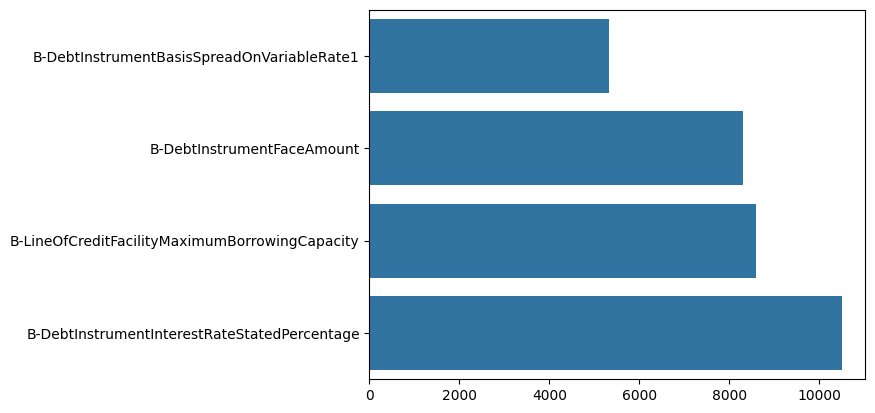

In [18]:
sns.barplot(x=filter_counts, y=filter_labels)

Now the new list of tags has N labels. Later the dataset will be remaped so all labeled samples are from 0 to N.

In [19]:
def map_filtered_labels(original_labels, filtered_labels_id):
    new_ner_tag_labels = ["O"] + [original_labels[id] for id in filtered_labels_id]
    label_map = {idx: new_ner_tag_labels.index(ner_tag) if ner_tag in new_ner_tag_labels else 0
                 for idx, ner_tag in enumerate(original_labels)}
    # inv_label_map = {v: k for k, v in label_map.items()}

    return label_map, new_ner_tag_labels

In [20]:
FiNER_label_map, FiNER_labels = map_filtered_labels(ner_tag_labels, filter_labels_id)

In [21]:
FiNER_labels

['O',
 'B-DebtInstrumentBasisSpreadOnVariableRate1',
 'B-DebtInstrumentFaceAmount',
 'B-LineOfCreditFacilityMaximumBorrowingCapacity',
 'B-DebtInstrumentInterestRateStatedPercentage']

Filter the data to include only sentences which at least one of the tags occur, by filtering the dataset to contain only labels in the list above (FiNER_labels).

Apply it to all data splits.

In [22]:
finer_data_filter = finer_data.filter(lambda x: bool(set(x["ner_tags"]) & set(filter_labels_id)))

Filter:   0%|          | 0/900384 [00:00<?, ? examples/s]

Filter:   0%|          | 0/112494 [00:00<?, ? examples/s]

Filter:   0%|          | 0/108378 [00:00<?, ? examples/s]

This is how the data splits look like after applying the filter.

In [23]:
finer_data_filter

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 28363
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 3741
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 3053
    })
})

### Create new labels

Now I filter the individual NER tags for each word in the dataset to contain only the list of selected tags. A new feature called "filtered_ner_tags" will be created with the new list of NER tags.

In [24]:
# Set the format back to default python dict
finer_data_filter.set_format(None)

In [25]:
def filter_ner_tags(example):
    _filtered_ner_tags = []
    for ner_tags in example["ner_tags"]:
        new_tags = np.zeros_like(ner_tags)
        for idx, tag in enumerate(ner_tags):
            if tag in filter_labels_id:
                new_tags[idx] = FiNER_label_map[tag]
        _filtered_ner_tags.append(new_tags)
    example["filtered_ner_tags"] = _filtered_ner_tags

    return example

In [26]:
finer_data_filter = finer_data_filter.map(filter_ner_tags, batched=True)

Map:   0%|          | 0/28363 [00:00<?, ? examples/s]

Map:   0%|          | 0/3741 [00:00<?, ? examples/s]

Map:   0%|          | 0/3053 [00:00<?, ? examples/s]

Display the dataset with the new feature, and compare a few samples for sanity check. "filtered_ner_tags" should contain only the list of top N tags filtered above, all other tags are remaped to "O". Also NER tag IDs should go from 0 to N.

In [27]:
finer_data_filter["train"].features.keys()

dict_keys(['id', 'tokens', 'ner_tags', 'filtered_ner_tags'])

In [28]:
finer_data_filter["train"]["ner_tags"][10]

[0, 0, 0, 0, 87, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [29]:
finer_data_filter["train"]["filtered_ner_tags"][10]

[0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [30]:
# np.array to display it better :)
np.array(finer_data_filter["train"]["ner_tags"][111])

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 90,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 90,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 87,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0])

In [31]:
np.array(finer_data_filter["train"]["filtered_ner_tags"][111])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

### Data preprocessing / Data Pipeline

Create the data pipeline to tokenize, pad, truncate and encode labels and tokens.

In [33]:
model_name = "distilbert/distilbert-base-uncased"

In [34]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained(model_name)


tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [35]:
# Sanity check
text = finer_data_filter["train"]["tokens"][0]
labels = finer_data_filter["train"]["filtered_ner_tags"][0]
print(text)
print(labels)

['As', 'of', 'November', '30', ',', '2015', ',', '$', '151.8', 'million', 'of', 'the', 'originated', 'loans', 'were', 'sold', 'into', 'a', 'securitization', 'trust', 'but', 'not', 'settled', 'and', 'thus', 'were', 'included', 'as', 'receivables', ',', 'net', '.', 'Notes', 'and', 'Other', 'Debts', 'Payable', 'In', 'November', '2013', ',', 'the', 'Rialto', 'segment', 'originally', 'issued', '$', '250', 'million', 'aggregate', 'principal', 'amount', 'of', 'the', '7.00', '%', 'senior', 'notes', 'due', '2018', '(', '"', '7.00', '%', 'Senior', 'Notes', '"', ')', ',', 'at', 'a', 'price', 'of', '100', '%', 'in', 'a', 'private', 'placement', '.']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [36]:
assert len(text)==len(labels), "text and labels must have same length"

In [37]:
#sample input encoded to test the process
encoded_input = tokenizer(text, truncation=True, max_length=512, is_split_into_words=True)
encoded_input

{'input_ids': [101, 2004, 1997, 2281, 2382, 1010, 2325, 1010, 1002, 16528, 1012, 1022, 2454, 1997, 1996, 7940, 10940, 2020, 2853, 2046, 1037, 10819, 9496, 3775, 9276, 3404, 2021, 2025, 3876, 1998, 2947, 2020, 2443, 2004, 28667, 7416, 12423, 2015, 1010, 5658, 1012, 3964, 1998, 2060, 13930, 3477, 3085, 1999, 2281, 2286, 1010, 1996, 15544, 2389, 3406, 6903, 2761, 3843, 1002, 5539, 2454, 9572, 4054, 3815, 1997, 1996, 1021, 1012, 4002, 1003, 3026, 3964, 2349, 2760, 1006, 1000, 1021, 1012, 4002, 1003, 3026, 3964, 1000, 1007, 1010, 2012, 1037, 3976, 1997, 2531, 1003, 1999, 1037, 2797, 11073, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [38]:
tokens = tokenizer.convert_ids_to_tokens(encoded_input["input_ids"])
print(tokens)

['[CLS]', 'as', 'of', 'november', '30', ',', '2015', ',', '$', '151', '.', '8', 'million', 'of', 'the', 'originated', 'loans', 'were', 'sold', 'into', 'a', 'sec', '##uri', '##ti', '##zation', 'trust', 'but', 'not', 'settled', 'and', 'thus', 'were', 'included', 'as', 'rec', '##ei', '##vable', '##s', ',', 'net', '.', 'notes', 'and', 'other', 'debts', 'pay', '##able', 'in', 'november', '2013', ',', 'the', 'ri', '##al', '##to', 'segment', 'originally', 'issued', '$', '250', 'million', 'aggregate', 'principal', 'amount', 'of', 'the', '7', '.', '00', '%', 'senior', 'notes', 'due', '2018', '(', '"', '7', '.', '00', '%', 'senior', 'notes', '"', ')', ',', 'at', 'a', 'price', 'of', '100', '%', 'in', 'a', 'private', 'placement', '.', '[SEP]']


The tokenization process introduces more items than the original list of tokens. Some words are split into two, and extra tokens like [CLS] and [SEP] are added. Here I align labels and words so they match again.

In [39]:
## Not running ASSERT statement because it will fail when running the code end-to-end
len(encoded_input["input_ids"])==len(labels)

False

In [40]:
word_ids = encoded_input.word_ids()
aligned_labels = [-100 if i is None else labels[i] for i in word_ids]
print(len(aligned_labels), len(encoded_input["input_ids"]))

97 97


In [41]:
# Simple process to align tokens and labels
def data_preprocess(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True,  max_length=512, is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples["filtered_ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        aligned_labels = [-100 if word_idx is None else label[word_idx] for word_idx in word_ids]
        labels.append(aligned_labels)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [42]:
# test if a sample matches
processed_data = data_preprocess(finer_data_filter["train"][0:1])
assert len(processed_data["input_ids"][0]) == len(processed_data["labels"][0]), "Size of input and labels don't match"

Run the data processing step for all data splits.
After that data should be encoded in the proper format, both tokens and labels.

In [43]:
tokenized_data = finer_data_filter.map(data_preprocess, batched=True, remove_columns=finer_data_filter["train"].column_names)

Map:   0%|          | 0/28363 [00:00<?, ? examples/s]

Map:   0%|          | 0/3741 [00:00<?, ? examples/s]

Map:   0%|          | 0/3053 [00:00<?, ? examples/s]

In [44]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 28363
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3741
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3053
    })
})

Below the data collator functionality is shown. It shapes the data into batches and also process it.

This should be how the data looks like when feeding into the model for training.

In [45]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

batch = data_collator([tokenized_data["train"][i] for i in range(2)])
batch

{'input_ids': tensor([[  101,  2004,  1997,  2281,  2382,  1010,  2325,  1010,  1002, 16528,
          1012,  1022,  2454,  1997,  1996,  7940, 10940,  2020,  2853,  2046,
          1037, 10819,  9496,  3775,  9276,  3404,  2021,  2025,  3876,  1998,
          2947,  2020,  2443,  2004, 28667,  7416, 12423,  2015,  1010,  5658,
          1012,  3964,  1998,  2060, 13930,  3477,  3085,  1999,  2281,  2286,
          1010,  1996, 15544,  2389,  3406,  6903,  2761,  3843,  1002,  5539,
          2454,  9572,  4054,  3815,  1997,  1996,  1021,  1012,  4002,  1003,
          3026,  3964,  2349,  2760,  1006,  1000,  1021,  1012,  4002,  1003,
          3026,  3964,  1000,  1007,  1010,  2012,  1037,  3976,  1997,  2531,
          1003,  1999,  1037,  2797, 11073,  1012,   102],
        [  101,  1999,  2233,  2297,  1010,  1996, 15544,  2389,  3406,  6903,
          3843,  2019,  3176,  1002,  2531,  2454,  1997,  1996,  1021,  1012,
          4002,  1003,  3026,  3964,  1010,  2012,  1037, 

### Metrics

Below are defined the metrics that will be used for evaluating the model.

They are based on [seqeval](https://huggingface.co/spaces/evaluate-metric/seqeval), that is a library meant for evaluating tasks such as named entity recognition.

We report below the following set of metrics:
* Precision,
* Recall,
* F1 score
* Accuracy
* Confusion Matrix

In [46]:
metric = datasets.load_metric("seqeval")

<ipython-input-46-b144b02b338d>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric("seqeval")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [47]:
# just test how the compute function works with a toy example
labels = [FiNER_labels[i] for i in finer_data_filter["train"]["filtered_ner_tags"][0]]
print(labels)
metric.compute(predictions=[labels], references=[labels])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DebtInstrumentFaceAmount', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DebtInstrumentInterestRateStatedPercentage', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


{'DebtInstrumentFaceAmount': {'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0,
  'number': 1},
 'DebtInstrumentInterestRateStatedPercentage': {'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0,
  'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

In [48]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [FiNER_labels[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [FiNER_labels[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

### Model training

The base model used is the DistilBERT-base-uncased. No extra parametrization needed, only the number of labels of the classifier are set to be the same as the target NER tags we're fine-tuning the model.

In [68]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(FiNER_labels))

In [50]:
BATCH_SIZE = 16
HF_TOKEN = "" #set only in runtime to save the model to the HF hub.

In [51]:
args = TrainingArguments(
    "distilbert-base-uncased-finetuned-FiNER",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=6,
    weight_decay=0.01,
    push_to_hub=False,
    push_to_hub_model_id="distilbert-base-uncased-finetuned-FiNER",
    push_to_hub_token=HF_TOKEN
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1815: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1834: FutureWarning: `--push_to_hub_model_id` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_model_id` instead and pass the full repo name to this argument (in this case bodias/distilbert-base-uncased-finetuned-FiNER).
  warnings.warn(


In [86]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Train the model for a few epochs

In [63]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.035400,0.037530,0.863942,0.899251,0.881243,0.987048
2,0.024200,0.029620,0.892892,0.915856,0.904228,0.989521
3,0.016600,0.029701,0.907883,0.920776,0.914284,0.990677
4,0.011700,0.030316,0.910141,0.929274,0.919608,0.991316
5,0.008600,0.032787,0.906474,0.933132,0.919610,0.991300
6,0.006200,0.033553,0.915437,0.932685,0.923980,0.991736


TrainOutput(global_step=10638, training_loss=0.0204571489105325, metrics={'train_runtime': 3077.0885, 'train_samples_per_second': 55.305, 'train_steps_per_second': 3.457, 'total_flos': 7803760318531848.0, 'train_loss': 0.0204571489105325, 'epoch': 6.0})

In [64]:
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

events.out.tfevents.1712772826.d631ab20ec6d.163.0:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/bodias/distilbert-base-uncased-finetuned-FiNER/commit/628873c9139dcb0c87459d8e66727ff84da8601c', commit_message='End of training', commit_description='', oid='628873c9139dcb0c87459d8e66727ff84da8601c', pr_url=None, pr_revision=None, pr_num=None)

### Model evaluation

Evaluate the test set on the metrics:
* Precision,
* Recall,
* F1 score
* Accuracy
* Confusion Matrix

In [53]:
trainer.evaluate(tokenized_data["test"])

{'eval_loss': 0.038737885653972626,
 'eval_precision': 0.9109878682842287,
 'eval_recall': 0.9192081701175154,
 'eval_f1': 0.9150795585111939,
 'eval_accuracy': 0.9912025017131716,
 'eval_runtime': 1141.0216,
 'eval_samples_per_second': 2.676,
 'eval_steps_per_second': 0.167}

In [88]:
predictions, labels, _ = trainer.predict(tokenized_data["test"])

In [89]:
predictions.shape

(3053, 512, 5)

In [128]:
labels.shape

(3053, 512)

In [54]:
predictions, labels, _ = trainer.predict(tokenized_data["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [FiNER_labels[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [FiNER_labels[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

{'DebtInstrumentBasisSpreadOnVariableRate1': {'precision': 0.9384380564741795,
  'recall': 0.9539694853891906,
  'f1': 0.9461400359066426,
  'number': 3867},
 'DebtInstrumentFaceAmount': {'precision': 0.8244788164088769,
  'recall': 0.8552493896058598,
  'f1': 0.8395822633110768,
  'number': 2867},
 'DebtInstrumentInterestRateStatedPercentage': {'precision': 0.9503166098392596,
  'recall': 0.954267547077525,
  'f1': 0.9522879804758998,
  'number': 4089},
 'LineOfCreditFacilityMaximumBorrowingCapacity': {'precision': 0.9074399531341535,
  'recall': 0.8920241865822056,
  'f1': 0.8996660374618848,
  'number': 3473},
 'overall_precision': 0.9109878682842287,
 'overall_recall': 0.9192081701175154,
 'overall_f1': 0.9150795585111939,
 'overall_accuracy': 0.9912025017131716}

Plot confusion matrix (excluding "O" tag)

In [56]:
 import matplotlib.pyplot as plt
from sklearn import metrics

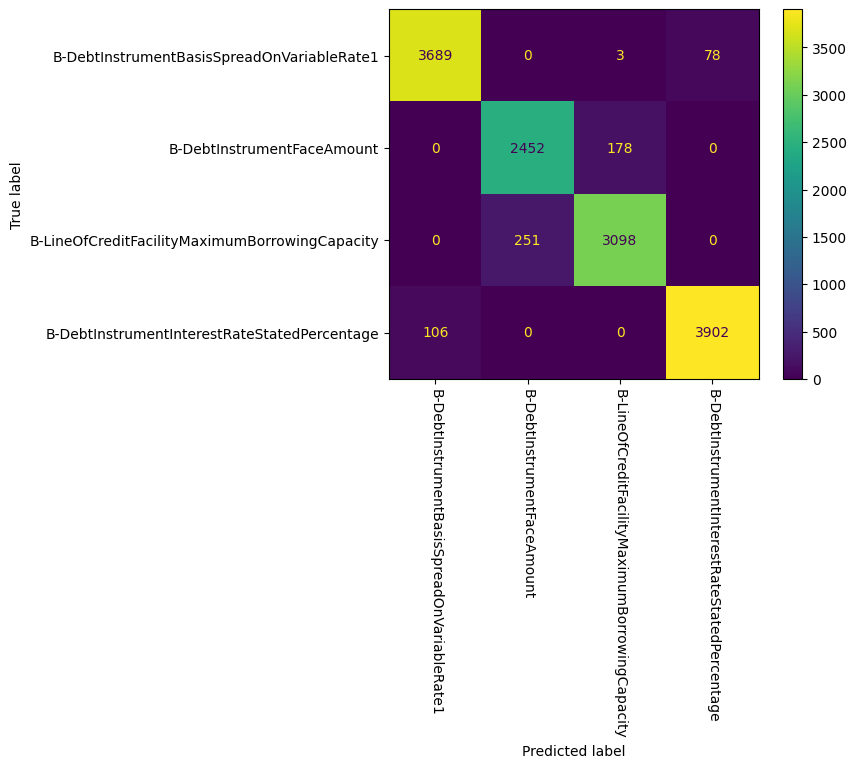

In [64]:
#flatten the array to plot the confusion matrix
true_predictions_1d = [item for sub_list in true_predictions for item in sub_list]
true_labels_1d = [item for sub_list in true_labels for item in sub_list]

confusion_matrix = metrics.confusion_matrix(true_labels_1d, true_predictions_1d, labels=FiNER_labels[1:])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=FiNER_labels[1:])

cm_display.plot(xticks_rotation=-90)
plt.show()

### Export to ONNX

In [65]:
tokenizer.save_pretrained("best-distilbert-base-uncased-FiNER")
model.save_pretrained("best-distilbert-base-uncased-FiNER")

In [113]:
!python -m transformers.onnx --model=best-distilbert-base-uncased-FiNER --framework=pt --feature=token-classification onnx/

2024-04-10 22:37:14.183408: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 22:37:14.183478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 22:37:14.185462: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-10 22:37:16.792703: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Using framework PyTorch: 2.2.1+cu121
/usr/local/lib/python3.10/dist-packages/transformers/models/distilbert/modeling_distilbert.py:246: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this 

### Load ONNX and test it

In [114]:
from onnxruntime import InferenceSession

tokenizer = AutoTokenizer.from_pretrained(model_name)
session = InferenceSession("onnx/model.onnx")

In [146]:
# ONNX Runtime expects NumPy arrays as input
sample_text = ['as', 'of', 'november', '30', ',', '2015', ',', '$', '151', '.', '8', 'million', 'of', 'the', 'originated', 'loans', 'were', 'sold', 'into', 'a', 'sec', '##uri', '##ti', '##zation', 'trust', 'but', 'not', 'settled', 'and', 'thus', 'were', 'included', 'as', 'rec', '##ei', '##vable', '##s', ',', 'net', '.', 'notes', 'and', 'other', 'debts', 'pay', '##able', 'in', 'november', '2013', ',', 'the', 'ri', '##al', '##to', 'segment', 'originally', 'issued', '$', '250', 'million', 'aggregate', 'principal', 'amount', 'of', 'the', '7', '.', '00', '%', 'senior', 'notes', 'due', '2018', '(', '"', '7', '.', '00', '%', 'senior', 'notes', '"', ')', ',', 'at', 'a', 'price', 'of', '100', '%', 'in', 'a', 'private', 'placement', '.']
inputs = tokenizer(sample_text, truncation=True, max_length=512, is_split_into_words=True, return_tensors="np")
inputs

{'input_ids': array([[  101,  2004,  1997,  2281,  2382,  1010,  2325,  1010,  1002,
        16528,  1012,  1022,  2454,  1997,  1996,  7940, 10940,  2020,
         2853,  2046,  1037, 10819,  1001,  1001, 24471,  2072,  1001,
         1001, 14841,  1001,  1001, 23564,  3508,  3404,  2021,  2025,
         3876,  1998,  2947,  2020,  2443,  2004, 28667,  1001,  1001,
         1041,  2072,  1001,  1001, 12436,  3468,  1001,  1001,  1055,
         1010,  5658,  1012,  3964,  1998,  2060, 13930,  3477,  1001,
         1001,  2583,  1999,  2281,  2286,  1010,  1996, 15544,  1001,
         1001,  2632,  1001,  1001,  2000,  6903,  2761,  3843,  1002,
         5539,  2454,  9572,  4054,  3815,  1997,  1996,  1021,  1012,
         4002,  1003,  3026,  3964,  2349,  2760,  1006,  1000,  1021,
         1012,  4002,  1003,  3026,  3964,  1000,  1007,  1010,  2012,
         1037,  3976,  1997,  2531,  1003,  1999,  1037,  2797, 11073,
         1012,   102]]), 'attention_mask': array([[1, 1, 1, 1, 

In [147]:
outputs = session.run(output_names=["logits"], input_feed=dict(inputs))
outputs[0].shape

(1, 119, 5)

In [148]:
prediction = np.argmax(outputs[0], axis=2)
prediction

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [157]:
original_tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].tolist()[0])
for word, tag in zip(original_tokens, prediction[0]):
    print(f"{word}:{FiNER_labels[tag]}")

[CLS]:O
as:O
of:O
november:O
30:O
,:O
2015:O
,:O
$:O
151:O
.:O
8:O
million:O
of:O
the:O
originated:O
loans:O
were:O
sold:O
into:O
a:O
sec:O
#:O
#:O
ur:O
##i:O
#:O
#:O
ti:O
#:O
#:O
za:O
##tion:O
trust:O
but:O
not:O
settled:O
and:O
thus:O
were:O
included:O
as:O
rec:O
#:O
#:O
e:O
##i:O
#:O
#:O
va:O
##ble:O
#:O
#:O
s:O
,:O
net:O
.:O
notes:O
and:O
other:O
debts:O
pay:O
#:O
#:O
able:O
in:O
november:O
2013:O
,:O
the:O
ri:O
#:O
#:O
al:O
#:O
#:O
to:O
segment:O
originally:O
issued:O
$:O
250:B-DebtInstrumentFaceAmount
million:O
aggregate:O
principal:O
amount:O
of:O
the:O
7:B-DebtInstrumentInterestRateStatedPercentage
.:B-DebtInstrumentInterestRateStatedPercentage
00:B-DebtInstrumentInterestRateStatedPercentage
%:O
senior:O
notes:O
due:O
2018:O
(:O
":O
7:B-DebtInstrumentInterestRateStatedPercentage
.:B-DebtInstrumentInterestRateStatedPercentage
00:B-DebtInstrumentInterestRateStatedPercentage
%:O
senior:O
notes:O
":O
):O
,:O
at:O
a:O
price:O
of:O
100:O
%:O
in:O
a:O
private:O
placement:O
.:O
[SEP]:O